# Exploration of Data.gov.sg's traffic images from traffic camera feed available.

Ref: https://beta.data.gov.sg/datasets/d_6cdb6b405b25aaaacbaf7689bcc6fae0/view

Data of interest: Traffic images

From a sample response of realtime air temperature, it was noted that there are only 3 sensors that detects the air temperature, whereas for rainfall, there are 64 of such.

In [17]:
from random import randint
from datetime import datetime
from typing import Union, Dict
import requests
from PIL import Image
from io import BytesIO

In [21]:
def api_query(api_link: str,  agent_id: str) -> Union[Dict,None]:
    """Function which executes query via an api link using a provided agent_id as an identifier to avoid rejection of query request

    Args:
        api_link (str): API Link which requests is to be made
        agent_id (str): Id used for request header

    Returns:
        Dictioanry containing request content. None when exception are encountered.
    """
    req_headers = {"User-agent": agent_id}
    try:
        res = requests.get(api_link,
                            headers=req_headers,
                            timeout=5)
        # Raise if HTTPError occured
        res.raise_for_status()

        # Check the status code before extending the number of posts
        if res.status_code == 200:
            print("Request sucessful with %s", res.status_code)
            the_json = res.json()
        return the_json['items']

    except requests.exceptions.HTTPError as errh:
        print(errh)
    except requests.exceptions.ConnectionError as errc:
        print(errc)
    except requests.exceptions.Timeout as errt:
        print(errt)
    except requests.exceptions.RequestException as err:
        print(err)
    return None

def query_traffic_metadata(api_link: str = "https://api.data.gov.sg/v1/transport/traffic-images", agent_id: str= "test_qzq"): 
    cctv_feed = api_query(api_link=api_link, agent_id=agent_id)
    all_traffic_metadata_dict = {}
    if not cctv_feed:
        print("No response received")
        return {}
    number_of_cameras = len(cctv_feed[0]["cameras"])
    print(number_of_cameras)
    for i in range(number_of_cameras):
        camera_feed = cctv_feed[0]["cameras"][i]

        # Process information to dictionary
        metadata_dict = {"timestamp" : camera_feed["timestamp"],
                "image_url": camera_feed["image"],
                "lat": camera_feed["location"]["latitude"],
                "lon": camera_feed["location"]["longitude"],
                "md5": camera_feed["image_metadata"]["md5"]
        }
        all_traffic_metadata_dict[camera_feed["camera_id"]] = metadata_dict
    return all_traffic_metadata_dict


def get_camera_feed(metadata_dict: Dict, camera_id: str="1005", agent_id: str="test_qzq"):
    try:
        # Extract the camera id from metadata_dict to obtain its metadata of interest
        specific_camera_metadata_dict = metadata_dict[camera_id]

    except KeyError:
        print("Invalid id received. No information obtained")

    # Randomised agent id
    rand_agent_id = agent_id + str(randint(0,500))
    try:
        response = requests.get(specific_camera_metadata_dict["image_url"],
                        stream=True,
                        headers={'User-agent': rand_agent_id},
                        timeout=5
                        )

        # Raise if HTTPError occured
        response.raise_for_status()
        # Write to a file if success and log the status
        img = Image.open(response.raw)
        return img
    except requests.exceptions.HTTPError as errh:
        print(errh)
    except requests.exceptions.ConnectionError as errc:
        print(errc)
    except requests.exceptions.Timeout as errt:
        print(errt)
    except requests.exceptions.RequestException as err:
        print(err)
    return None

In [14]:
metadata = query_traffic_metadata()
metadata

Request sucessful with %s 200


{'1002': {'timestamp': '2023-11-13T22:26:42+08:00',
  'image_url': 'https://images.data.gov.sg/api/traffic-images/2023/11/67c3f188-b28b-495b-9739-f059b18ba6b9.jpg',
  'lat': 1.319541067,
  'lon': 103.8785627,
  'md5': 'afd1d3f4a017742b896636f72fbe855d'},
 '1003': {'timestamp': '2023-11-13T22:26:42+08:00',
  'image_url': 'https://images.data.gov.sg/api/traffic-images/2023/11/78241fde-ce30-4e34-a97a-1eb81f807ce6.jpg',
  'lat': 1.323957439,
  'lon': 103.8728576,
  'md5': '5b9e70a9cc0b58b55eaaf43ae1983e07'},
 '1004': {'timestamp': '2023-11-13T22:26:42+08:00',
  'image_url': 'https://images.data.gov.sg/api/traffic-images/2023/11/a6b9307c-6f8e-497a-8b03-69ad7794ff11.jpg',
  'lat': 1.319535712,
  'lon': 103.8750668,
  'md5': 'ce438cca0a261041f238e1473ec3a8f2'},
 '1005': {'timestamp': '2023-11-13T22:26:42+08:00',
  'image_url': 'https://images.data.gov.sg/api/traffic-images/2023/11/5c5315eb-bc11-4822-8696-8d18e7debe40.jpg',
  'lat': 1.363519886,
  'lon': 103.905394,
  'md5': '02a43b86f5ca3dcd1

Try reading image from obtained metadata

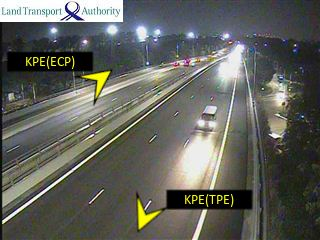

In [22]:
get_camera_feed(metadata_dict=metadata, camera_id="1005")